# Visualizing ZED Mini SLAM Pose Estimation with Covariance
This script is used to visualize ZED mini datasets collected as part of group 19's EECE 5554 final project. The estimated pose and covariance come from the the zed_wrapper topic "/zedm/zed_node/pose_with_covariance" which outputs the current estimated pose, plus pose covariance.

Group Members:
- Colin Keil
- Marcos Oliveira
- Andac Demir
- Yating Chen

Notebook By: Colin Keil

Note, in order to run the notebook, the compressed pose csv files located in ../datasets/bag_csv/ must be decompressed.

In [1]:
#import necessary plotting and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [108]:
#read in data
file_name = 'kitchen_loop_poses.csv'
file_loc = '../datasets/bag_csv'
pose_bag = pd.read_csv(file_loc+'/'+file_name)

#remove data with NAN (NaN's get added at the end of bags))
pose_bag = pose_bag.loc[ pose_bag.notnull().all(axis=1)]
pose_bag = pose_bag.drop( pose_bag.index[-1])


# print(pose_bag.head())
# print(len(pose_bag))
#break data out into numpy arrays
# get rid of the last value, because it seems to be an error
time = pose_bag['field.header.stamp'].values / 1000000000
time = time - time[0]
# print(len(time))
pos = np.empty((len(pose_bag),3))
pos[:,0] = pose_bag['field.pose.pose.position.x']
pos[:,1] = pose_bag['field.pose.pose.position.y']
pos[:,2] = pose_bag['field.pose.pose.position.z']
orient = np.empty((len(pose_bag),4))
orient[:,0] = pose_bag['field.pose.pose.orientation.x']
orient[:,1] = pose_bag['field.pose.pose.orientation.y']
orient[:,2] = pose_bag['field.pose.pose.orientation.z']
orient[:,3] = pose_bag['field.pose.pose.orientation.w']
covariance = np.empty((len(pose_bag),6,6))
for i in range(36):
    covariance.reshape(len(pose_bag),36)[:,i] = pose_bag['field.pose.covariance'+str(i)]


## Inspecting Covariace Matrix
We can check a random covariace matrix to check that the formating makes sense. Notice that the matrix is symmetrical as expected, and that the first three diagonal elements have the largest magnitude. In general this is what we would expect to see, as these three represent position variance. Note that position and orientation do not have the same units (orientation uses radians and position, meters) so the scale of position vs orientation elements is not 1 to 1.

In [109]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)}) #reduces the number of displayed decimals
rand_i = int(len(pose_bag)/3)
print(covariance[rand_i])

[[1.276e-05 -2.407e-06 -1.568e-07 1.264e-06 3.938e-06 -2.697e-07]
 [-2.407e-06 1.230e-05 -1.495e-07 -3.544e-06 -5.543e-07 7.640e-07]
 [-1.568e-07 -1.495e-07 8.072e-06 3.359e-07 -3.613e-07 -1.097e-07]
 [1.264e-06 -3.544e-06 3.359e-07 2.382e-06 6.889e-07 -5.580e-07]
 [3.938e-06 -5.543e-07 -3.613e-07 6.889e-07 2.966e-06 -2.045e-07]
 [-2.697e-07 7.640e-07 -1.097e-07 -5.580e-07 -2.045e-07 2.992e-06]]


## Plotting Covariance
Let's directly plot the diagonal covariance entries to try and get a feel for the data. As we should expect, we see the covariance entries start out at zero, and generally grow intill a loop closure is detected. There are several loop closures identifiable by the sawtooth motion in the plot. We can also look at changes in estimated position, and note that we see relatively large jumps in the position data at the loop closure points. Note that in the kitchen loop dataset the covariance jumps suddenly at the last value. I think this is an error, so I removed it.

Text(0, 0.5, 'Cov (rad^2)')

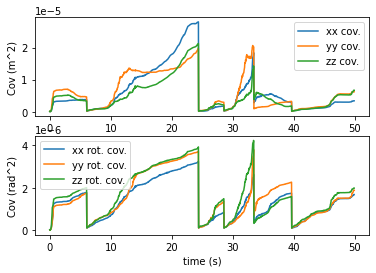

In [138]:
#get change in position and plot it
pos_dif = np.diff(pos, axis = 0)
pos_dif_dif = np.diff(pos_dif, axis = 0)

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
# ax3 = fig.add_subplot(3,1,3)
# fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(time,covariance[:,0,0], label = 'xx cov.')
ax1.plot(time,covariance[:,1,1], label = 'yy cov.')
ax1.plot(time,covariance[:,2,2], label = 'zz cov.')
ax2.plot(time,covariance[:,3,3], label = 'xx rot. cov.')
ax2.plot(time,covariance[:,4,4], label = 'yy rot. cov.')
ax2.plot(time,covariance[:,5,5], label = 'zz rot. cov.')
# ax3.plot(time[2:],pos_dif_dif[:,0], label = 'x accel')
# ax3.plot(time[2:],pos_dif_dif[:,1], label = 'y accel')
# ax3.plot(time[2:],pos_dif_dif[:,2], label = 'z accel')
ax1.legend()
ax2.legend()
ax2.set_xlabel('time (s)')
ax1.set_ylabel('Cov (m^2)')
ax2.set_ylabel('Cov (rad^2)')
# ax3.set_ylabel('Accel. (m/s^2)')

## Identifying Loop Closures
As noted in the above block, we can identify loop closures when thecovariance decreases suddenly. We may want to plot the positions when this happens later, so let's identify the loop closures.

In [164]:
#change in covariance, using diagonal as proxy for magnitude
cov_diff = np.diff(np.diagonal(covariance, axis1 = 1, axis2 = 2), axis = 0)
# cov_diff_diff = np.diff(cov_diff, axis = 0)
diff_mag = np.mean(cov_diff, axis = 1)*100000 #srbitrary scaling to make thresholding easier

indices = np.array(range(len(diff_mag)))
loop_closures = indices[diff_mag<-0.05]+1
print('Loop Closures occur at indices: {}'.format(loop_closures))
# #visualize for debugging
# fig, ax = plt.subplots()
# ax.plot(time[1:],diff_mag)


Loop Closures occur at indices: [ 182  732  857 1004 1190]


## Visualizing Covariance
The position portion of the covariance matrix can be visualized as a confidence interval in 3D space. The SLAM formulation assumes a gausian distribution on uncertainty in this case, so the confidence interval will be a 3D elipsoid. We can calculate the sape of this elipsoid by extracting the eiganvectors of the postion covariance matrix. This strategy can also be applied to the rotation covariance, but the confidence interval is not as easy to interpret as a region in 3D space, so I will just use position.

For refference, we will look at the covariance just before and after the loop closure after the first lap of the kitchen. As expected, we see that the covariance is much smaller after the closure.

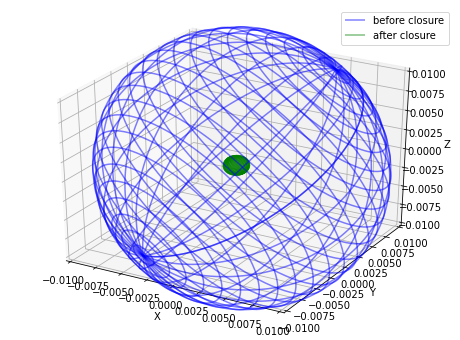

In [188]:
from mpl_toolkits.mplot3d import Axes3D

position_covariance = covariance[:,:3,:3] #top left corner of the cov matrix

def draw_confidence_ellipse(position_covariance, 
                            position, 
                            ax, 
                            nstd = 3, 
                            scale = 1, 
                            plot_center = True, 
                            alpha = 0.05,
                            color = 'b',
                            label = None):
    '''draws the confidence ellipsoid for the position, on the supplied axis.
    Assumes 3 standard deviation cofidence window by default.
    
    scale can be used to artificially increase the plotted size of the ellipse.'''
    
    #get the eigan vectors and values
    eigs, eig_vecs = np.linalg.eig(position_covariance)
    confidence = scale*nstd*np.sqrt(eigs)
    # print(eigs); print(eig_vecs)

    #generate elipsoid patches
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = confidence[0] * np.outer(np.cos(u), np.sin(v))
    y = confidence[1] * np.outer(np.sin(u), np.sin(v))
    z = confidence[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], eig_vecs) + position
    
    #add to axis
    ref = ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=color, alpha=alpha, label = label)
    return ref #return the refference to make legends simpler

i = loop_closures[1]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

draw_confidence_ellipse(position_covariance[i-1], np.zeros(3), ax, alpha = 0.5,color = 'b', label = 'before closure')
draw_confidence_ellipse(position_covariance[i], np.zeros(3), ax, alpha = 0.5,color = 'g', label = 'after closure')
ax.legend()
ax.set_xlim(-0.01, 0.01); ax.set_ylim(-0.01, 0.01); ax.set_zlim(-0.01, 0.01);

## Visualizing path with covariance
We can now plot the path of the camera with the covariance overlaid. To make the visualization cleaner we will only plot the first lap. We can also directly look at the covariance before and after the loop clsures. Note that in the below visuals I have scaled up the covaraince confidence intervals by a factor of 10 to make the changes more obvious.

In [202]:
import matplotlib.lines as mlines
def plot_cov_series(covariance, position, indices, ax, scale = 1, plot_center = True, color = 'b', alpha = 0.2):
    '''Plots a position ocvariance ellipse for each position, 
    covariance pair indicated by the indices list'''
    #iterate over supplied indices
    elps = []
    for i in indices:
        draw_confidence_ellipse(covariance[i], position[i], ax, scale=scale,color=color, alpha = alpha)
        line = mlines.Line2D([], [], color=color)
        elps.append(line)
    #add center points
    if plot_center:
        ax.scatter(position[indices,0],position[indices,1],position[indices,2],color=color)
        
    return elps

# print(len(time))
# print(pos[0])

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
half = int(len(time)/2)
path = ax.plot3D(pos[:half,0],pos[:half,1],pos[:half,2])
series = list(range(half))[0::50]
el_list = plot_cov_series(position_covariance, pos, series, ax, scale = 10, color = 'b')
half_closures = loop_closures[loop_closures<half]
el_list_before = plot_cov_series(position_covariance, 
                                 pos, 
                                 half_closures-1, 
                                 ax, 
                                 alpha = 0.1, 
                                 scale = 10, 
                                 color = 'r')
el_list_after = plot_cov_series(position_covariance, 
                                pos, 
                                half_closures, 
                                ax, 
                                alpha = 0.5, 
                                scale = 10, 
                                color = 'g', 
                                plot_center = False)
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1);
ax.legend([el_list[0], el_list_before[0],el_list_after[0]],
          ['Covariance','Cov. Before Closure', 'Cov. After Closure'])

In the above plot, ignoring the small closure at the beginning of the loop, we see that the covariance generally grow as the loop progresses, untill the ZED approximately reaches the starting position and there is a significant loop closure. The covariance after the loop clsures are difficult to see, becasue they are an order of magnitude more certain.

## Inspecting Covariance vs Updated Position
We would like to see how far the updated position moves when a loop closure occurs. In general we would expect that the change in position is not much more than the confidence interval on before the loop closure. In order to inspect this more closely, we will zoom in on the portion of the path right around the large loop clsoure visualized above.

In [220]:
interval = [loop_closures[1]-10,loop_closures[1]+10]
close = loop_closures[1]
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot3D(pos[interval[0]:close,0],
          pos[interval[0]:close,1],
          pos[interval[0]:close,2],'-ob', label = 'path')
ax.plot3D(pos[close:interval[1],0],
          pos[close:interval[1],1],
          pos[close:interval[1],2],'-ob')
ax.plot3D(pos[close-1:close+1,0],
          pos[close-1:close+1,1],
          pos[close-1:close+1,2],'--b')

#plot covariance matrices 
draw_confidence_ellipse(position_covariance[loop_closures[1]-1], 
                            pos[loop_closures[1]-1], 
                            ax, 
                            nstd = 3, 
                            scale = 1, 
                            plot_center = True, 
                            alpha = 0.5,
                            color = 'r',
                            label = 'cov. before closure')
draw_confidence_ellipse(position_covariance[loop_closures[1]], 
                            pos[loop_closures[1]], 
                            ax, 
                            nstd = 3, 
                            scale = 1, 
                            plot_center = True, 
                            alpha = 0.5,
                            color = 'g',
                            label = 'cov. after closure')
ax.legend()

So here we see that the position discontinuity is similar to the 99% confidence interval for the position covaraiance. Again, this is what we would expect to happen. If the position error is significantly larger than the covariance bound, there is no reason for the internal calculations to assume a loop clsoure has been observed. Instead it will just assume some very similar but new features are being observed. Note that the largest the uncertainty got in this dataset is apptoximatelt $\pm$2cm. 

## Loop Closure Failures
Let's look at a different scenario where the model fails to close the loop. To do so we can look at the medium outdoor dataset.

In [221]:
#read in data
file_name = 'medium_outdoor_poses.csv'
file_loc = '../datasets/bag_csv'
pose_bag = pd.read_csv(file_loc+'/'+file_name)

#remove data with NAN (NaN's get added at the end of bags))
pose_bag = pose_bag.loc[ pose_bag.notnull().all(axis=1)]
pose_bag = pose_bag.drop( pose_bag.index[-1]) #last values are weird

#break data out into numpy arrays
# get rid of the last value, because it seems to be an error
time = pose_bag['field.header.stamp'].values / 1000000000 #convert to seconds
time = time - time[0]
# print(len(time))
pos = np.empty((len(pose_bag),3))
pos[:,0] = pose_bag['field.pose.pose.position.x']
pos[:,1] = pose_bag['field.pose.pose.position.y']
pos[:,2] = pose_bag['field.pose.pose.position.z']
orient = np.empty((len(pose_bag),4))
orient[:,0] = pose_bag['field.pose.pose.orientation.x']
orient[:,1] = pose_bag['field.pose.pose.orientation.y']
orient[:,2] = pose_bag['field.pose.pose.orientation.z']
orient[:,3] = pose_bag['field.pose.pose.orientation.w']
covariance = np.empty((len(pose_bag),6,6))
for i in range(36):
    covariance.reshape(len(pose_bag),36)[:,i] = pose_bag['field.pose.covariance'+str(i)]

Let's plot the whole path, just to get a feel for the data.

In [223]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot3D(pos[:,0],
          pos[:,1],
          pos[:,2],'-b', label = 'path')

We see that the path appears as a large spiral. In reality this was two laps around a small apartment complex, so there is significant z-axis drift, and failuare to make any successful loop closures. If we visualized the diagonal elements of the covariance, we can see that it is generally increasing, with no sudden decreases, indicating groming uncertainty and no loop closures. We do notice that the covariance does not monotonically increase, which is interesting. In this case, the pweiods where the covariance is decreasing seem to be periods where the camera is moving in straight lines, so the camera is constantly able to view the same features. Note that the uncertainty is on the order of several centimeters.

Text(0, 0.5, 'Cov (rad^2)')

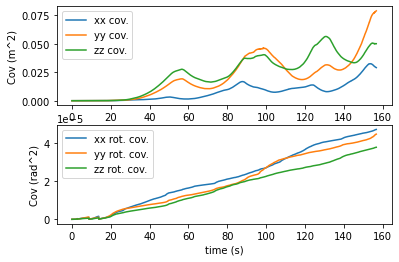

In [225]:
#get change in position and plot it
pos_dif = np.diff(pos, axis = 0)
pos_dif_dif = np.diff(pos_dif, axis = 0)

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(time,covariance[:,0,0], label = 'xx cov.')
ax1.plot(time,covariance[:,1,1], label = 'yy cov.')
ax1.plot(time,covariance[:,2,2], label = 'zz cov.')
ax2.plot(time,covariance[:,3,3], label = 'xx rot. cov.')
ax2.plot(time,covariance[:,4,4], label = 'yy rot. cov.')
ax2.plot(time,covariance[:,5,5], label = 'zz rot. cov.')

ax1.legend()
ax2.legend()
ax2.set_xlabel('time (s)')
ax1.set_ylabel('Cov (m^2)')
ax2.set_ylabel('Cov (rad^2)')

Now, let's overlay the uncertainty with the path and see if we would expect to see loop closures. Covariance confidence elipsoids are displayed true to scale.

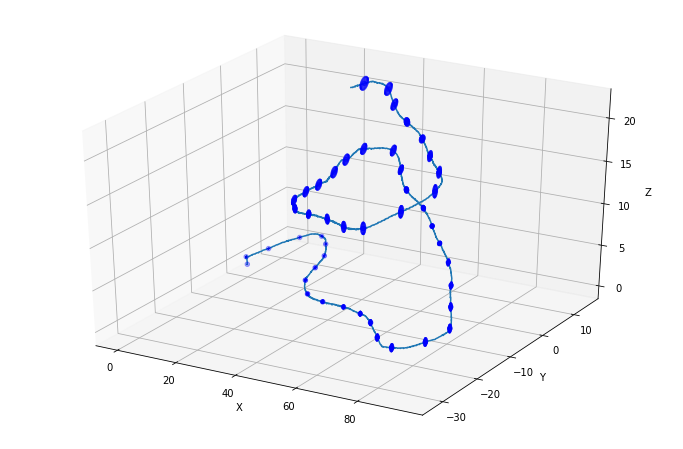

In [228]:
position_covariance = covariance[:,:3,:3] #top left corner of the cov matrix

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
half = int(len(time)/2)
path = ax.plot3D(pos[:,0],pos[:,1],pos[:,2])
series = list(range(len(time)))[0::100]
el_list = plot_cov_series(position_covariance, pos, series, ax, scale = 1, color = 'b')

Looking at the covaraince, overlaid with the tracked position, we see that the reletive position error between corresponding sections of the loop, is at least 10x greater than the 99% positionconfidence interval displayed on the chart. This means that the ZED is overestimating it's position accuracy, leading to a failure to register loop closures. Though it is slightly difficult to make out, we can note that the ZED uncertainty is greatest in the z-direction, which makes sense, becasue there is very obvious z-axis drift. It is not completely clear why this would happen. Perhaps the bouncing walking motion affected the intertial accuracy, or perhaps something about the features present in the environment results in greater certainty with regards to horizontal movement. 

## Conclusions
The ZED mini camera is able to accurately do loop closures for small loops. There appears to be a bias in the camera that overestimates certainty, causing larger loops to fail. This is not an exhaustive analysis, but is indicative of what we saw in our datasets.